<a href="https://www.kaggle.com/code/rashidrk/tb-detection-with-yolo-12?scriptVersionId=235220754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
!pip install ultralytics -q
from PIL import Image, ImageDraw
from pathlib import Path
import os
import xml.etree.ElementTree as ET
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml
import matplotlib.patches as patches
import random
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 36.1 MB/s eta 0:00:00


In [2]:
annotations_path = Path("/kaggle/input/tbx-11/TBX11K/annotations/xml")
images_path = Path("/kaggle/input/tbx-11/TBX11K/imgs")

annotations = os.listdir(annotations_path)
images = os.listdir(images_path)

annotations.sort()
images.sort()

In [3]:
def read_file_paths(file_path : str):
    with open(file_path, 'r') as f:
        all_files = f.readlines()
        return all_files


train_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_train.txt")
test_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")
val_paths = read_file_paths("/kaggle/input/tbx-11/TBX11K/lists/all_test.txt")

test_paths[:4]

['test/unknown_1.png\n',
 'test/unknown_2.png\n',
 'test/unknown_3.png\n',
 'test/unknown_4.png\n']

In [4]:
len(train_paths)

6888

In [5]:
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Basic file info
    filename = root.find('filename').text
    segmented = int(root.find('segmented').text)

    # Image size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = int(obj.find('truncated').text)
        difficult = int(obj.find('difficult').text)

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        annotations.append({
            'name': name,
            'pose': pose,
            'truncated': truncated,
            'difficult': difficult,
            'bbox': {
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            }
        })

    return {
        'filename': filename,
        'segmented': segmented,
        'size': {
            'width': width,
            'height': height
        },
        'objects': annotations
    }


In [6]:
parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

{'filename': 'tb0003',
 'segmented': 0,
 'size': {'width': 2840, 'height': 2827},
 'objects': [{'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 1446, 'ymin': 250, 'xmax': 2007, 'ymax': 1017}},
  {'name': 'ObsoletePulmonaryTuberculosis',
   'pose': 'unspecified',
   'truncated': 0,
   'difficult': 0,
   'bbox': {'xmin': 618, 'ymin': 391, 'xmax': 1177, 'ymax': 1013}}]}

In [7]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [8]:
def plot_image_with_bboxes(image_path, annotation_data):
    # Load and resize the image to match annotation size
    image = Image.open(image_path)
    annotated_width = annotation_data['size']['width']
    annotated_height = annotation_data['size']['height']
    image = image.resize((annotated_width, annotated_height))

    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Assign unique colors to each class
    # class_names = list(set(obj['name'] for obj in annotation_data['objects']))
    # color_map = {cls: (random.random(), random.random(), random.random()) for cls in class_names}

    # Draw each bounding box
    for obj in annotation_data['objects']:
        bbox = obj['bbox']
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        box_width = xmax - xmin
        box_height = ymax - ymin

        label = obj['name']

        # Draw rectangle
        rect = patches.Rectangle(
            (xmin, ymin), box_width, box_height,
            linewidth=2, edgecolor="red", facecolor='none'
        )
        ax.add_patch(rect)

        # Add class label
        ax.text(xmin, ymin - 5, label, color="red", fontsize=10, weight='bold', backgroundcolor='white')

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [9]:
annotations[-1]

'tb1199.xml'

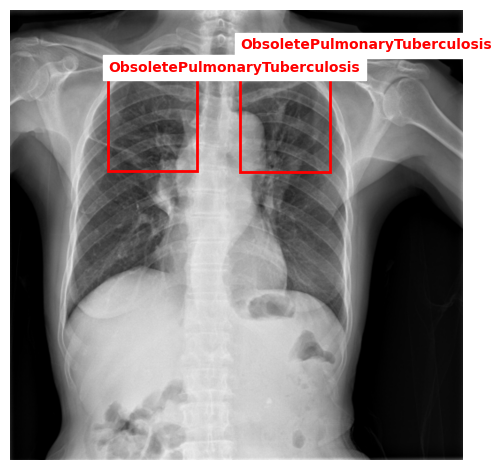

In [10]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0003.png", objects)

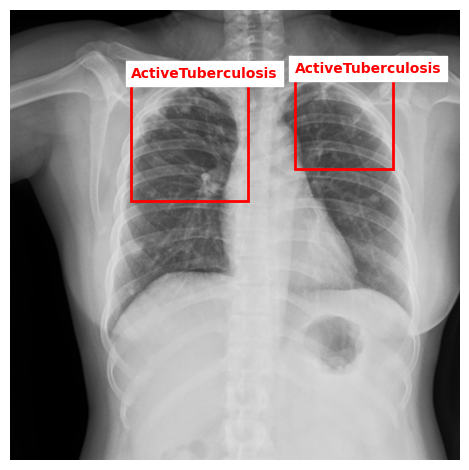

In [11]:
objects = parse_xml("/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0235.xml")

plot_image_with_bboxes("/kaggle/input/tbx-11/TBX11K/imgs/tb/tb0235.png", objects)

In [12]:
classes_set = set([])

for annon in annotations:
    objects = parse_xml(annotations_path / annon)
    objects = objects['objects']
    for obj in objects:
        classes_set.add(obj['name'])

In [13]:
classes_set

{'ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis'}

# prep data for training

In [14]:
class_map = {
    "TB" : 0
}

In [15]:
def convert_to_yolo_format(xml_path, output_dir):
    """
    Converts XML annotations to YOLO format.

    Args:
        xml_path: Path to the XML annotation file.
        output_dir: Directory to save the YOLO annotation files.
        class_map: Dict mapping class names to YOLO class IDs

    Returns:
        None: Saves YOLO annotation files to output_dir.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Image size
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)

    yolo_annotations = []

    for obj in root.findall('object'):
        name = obj.find('name').text

        # Bounding box
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Normalize for YOLO format
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        box_width = (xmax - xmin) / img_width
        box_height = (ymax - ymin) / img_height

        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    # Save to .txt file in YOLO format
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    output_file = output_path / (xml_path.stem + ".txt")
    
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_annotations))


In [16]:
annotations = [annotations_path / annon for annon in annotations]
annotations[:10]

[PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0003.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0004.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0005.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0006.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0007.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0009.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0012.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0014.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0015.xml'),
 PosixPath('/kaggle/input/tbx-11/TBX11K/annotations/xml/tb0017.xml')]

In [17]:
train_data, val_data = train_test_split(annotations, random_state = 42, test_size = 0.2)

In [18]:
output_dir = Path("/kaggle/working/")

directories = ['train', 'val']
for data_dir in directories:
    images_output_dir = output_dir / f"{data_dir}/images"
    labels_output_dir = output_dir / f"{data_dir}/labels"

    os.makedirs(images_output_dir, exist_ok = True)
    os.makedirs(labels_output_dir, exist_ok = True)

In [19]:
directories_dict = {
    "train" : Path("/kaggle/working/train"),
    "val" : Path("/kaggle/working/val")
}

In [20]:
annotations[0].stem

'tb0003'

In [21]:
def move_image_to_dir(image_path, images_output_dir):
    image = Image.open(image_path)
    images_output_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    image.save(images_output_dir / Path(image_path).name)


def generate_yolo_dir(data_list : List, data_dir):
    images_output_dir = directories_dict[data_dir] / "images"
    labels_output_dir = directories_dict[data_dir] / "labels"
    
    for annon_path in tqdm(
        data_list,
        total=len(data_list),
        desc="Processing Images and Annotations"
    ):
        img_path = images_path / "tb" / f"{annon_path.stem}.png"
        move_image_to_dir(img_path, images_output_dir)
        convert_to_yolo_format(annon_path, labels_output_dir)

In [22]:
generate_yolo_dir(train_data, "train")

Processing Images and Annotations: 100%|██████████| 640/640 [00:52<00:00, 12.28it/s]


In [23]:
generate_yolo_dir(val_data, "val")

Processing Images and Annotations: 100%|██████████| 160/160 [00:12<00:00, 12.36it/s]


In [24]:
# display one of the files
with open("/kaggle/working/train/labels/tb0003.txt") as f:
    print(f.read())

0 0.607923 0.224089 0.197535 0.271312
0 0.316021 0.248320 0.196831 0.220021


In [25]:
num_classes = 1
names = ['TB']

dict_file = {
    'train': str(directories_dict['train']),
    'val': str(directories_dict['val']),
    'nc': num_classes,
    'names': names,
    'augment': { # apply data augmentations
        'flipud': 0.0,  # Probability of vertical flip
        'fliplr': 0.5,  # Probability of horizontal flip
        'hsv_h': 0.015,  # HSV hue augmentation 
        'hsv_s': 0.7,  # HSV saturation augmentation
        'hsv_v': 0.4   # HSV value augmentation
    }
}

# Save to the data.yaml file
with open("/kaggle/working/data.yaml", 'w') as file:
    yaml.dump(dict_file, file, default_flow_style=False)

In [26]:
# display 
with open("/kaggle/working/data.yaml", "r") as f:
    print(f.read())

augment:
  fliplr: 0.5
  flipud: 0.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
names:
- TB
nc: 1
train: /kaggle/working/train
val: /kaggle/working/val



In [27]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
except Exception as e:
    print(e)
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rashidkisejjere0784. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
from ultralytics import YOLO

model = YOLO('yolo12m.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 39.0M/39.0M [00:00<00:00, 107MB/s] 


In [29]:
results = model.train(data="/kaggle/working/data.yaml",
                      epochs=100,
                      patience=40,
                      cos_lr = True,
                      seed = 42)

Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=40, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 44.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2689536  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 174MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3074.1±796.3 MB/s, size: 201.6 KB)


train: Scanning /kaggle/working/train/labels... 640 images, 1 backgrounds, 0 corrupt: 100%|██████████| 640/640 [00:00<00:00, 1135.54it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 840.5±752.6 MB/s, size: 197.0 KB)


val: Scanning /kaggle/working/val/labels... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 1074.06it/s]

val: New cache created: /kaggle/working/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0005), 129 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.8G      2.266      3.649      2.391         30        640: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.7G      2.228      2.831      2.316         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:01<00:07,  1.76s/it]/usr/local/lib/python3.10/dist-packages/ultralytics/engine/validator.py:289: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        160        247    0.00185      0.223    0.00115   0.000282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.5G      2.264      2.754      2.289         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        160        247          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.5G      2.168      2.604      2.192         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247     0.0144     0.0769    0.00443    0.00138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.5G      2.124      2.559      2.162         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        160        247     0.0803     0.0729      0.023    0.00535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.5G      2.116      2.449      2.162         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247     0.0626     0.0773    0.00955    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.5G      2.045      2.363      2.087         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.255      0.178      0.113     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.7G       1.99      2.407      2.047         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.29       0.36      0.225     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G      2.037      2.383      2.087         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247      0.184      0.239      0.121     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.5G      2.066      2.332        2.1         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.194      0.287       0.14     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.5G      2.024      2.292      2.045         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247       0.47      0.428      0.389      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.5G       1.99      2.221      2.056         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        160        247      0.263      0.425      0.265     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.5G      1.918      2.183      1.993         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.255      0.255      0.166     0.0473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.5G      1.966      2.163      1.983         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247     0.0496      0.109     0.0193    0.00442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.5G      1.903      2.139      1.962         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.525      0.494      0.488       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.5G        1.9      2.147      1.936         47        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.363       0.48      0.355      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.5G      1.899       2.12      1.951         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.447      0.457      0.432      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.5G      1.922      2.048       1.96         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.459      0.385      0.373      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.5G      1.911      2.064       1.94         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.444      0.543      0.442      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.5G      1.882      2.056      1.959         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.505      0.571      0.507      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.5G      1.897      2.048      1.931         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.59      0.522       0.54      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.5G      1.862      1.973      1.874         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.42      0.405       0.33     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.5G      1.864      2.004      1.913         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.586      0.575      0.572      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.5G       1.86      1.934      1.905         36        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.591      0.578       0.57      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.5G      1.808      1.921      1.873         49        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.554      0.598      0.563      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.5G      1.811       1.94      1.875         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.423      0.575      0.462      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.5G      1.841      1.901      1.867         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.587      0.518      0.525      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.4G      1.827      1.915      1.895         38        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.597      0.632      0.616      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.4G      1.806       1.89      1.853         30        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.569      0.563      0.528      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.5G        1.8      1.892      1.868         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.594       0.51      0.517      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.5G        1.8      1.905      1.859         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.595      0.494       0.54      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.5G      1.834      1.836      1.878         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.598      0.596      0.577      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.5G      1.819      1.864      1.874         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.62      0.575      0.604      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.5G      1.794      1.825      1.846         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        160        247      0.664      0.633      0.651      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.5G      1.794      1.872      1.824         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.694      0.628      0.651      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.5G      1.749      1.799      1.817         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.58      0.522      0.556      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.5G      1.779      1.788      1.846         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.616      0.663      0.636       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.5G      1.816       1.82      1.855         28        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.605      0.563      0.578      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.5G      1.781      1.797      1.826         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247       0.56      0.543      0.534      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.5G      1.757      1.776      1.808         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247       0.66      0.587       0.63      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.5G      1.743      1.721      1.818         26        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.727      0.607      0.658      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G       1.77      1.748      1.824         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.592      0.546      0.554      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.4G      1.762      1.812      1.841         54        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.663      0.623      0.604      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.5G      1.733      1.766      1.816         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.689      0.654      0.665      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.5G      1.736      1.706      1.786         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.725      0.636       0.65      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.5G      1.745       1.75      1.824         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.709      0.641      0.677      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.5G       1.74      1.714      1.822         52        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.709      0.579      0.659       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.5G      1.733      1.712      1.783         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.596      0.563      0.606      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.5G      1.714      1.647      1.774         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.675      0.648      0.654      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.5G      1.711      1.661      1.776         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.733      0.619      0.666       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.4G      1.717      1.615      1.778         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.645      0.648      0.652      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.5G      1.684      1.627      1.751         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.748      0.637      0.689      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.5G      1.672      1.594      1.735         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        160        247      0.741       0.65      0.693      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.5G      1.648      1.568      1.725         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.729      0.655       0.71      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.5G      1.701      1.627      1.766         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.655      0.615       0.63      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.5G      1.665      1.596      1.736         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        160        247      0.697      0.599      0.652      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.5G      1.695      1.636      1.748         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.787      0.619      0.725      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.5G      1.669      1.609      1.754         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.759      0.587      0.685      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.5G      1.661      1.567      1.743         35        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.714      0.607      0.663      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.5G      1.646       1.53      1.717         40        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.658      0.672       0.66      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.5G      1.664      1.564      1.748         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247        0.7      0.688      0.726      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.5G      1.632      1.554      1.716         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.648      0.672        0.7      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.5G      1.652      1.525      1.727         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.734       0.66      0.741      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.5G      1.645      1.511      1.716         34        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.677      0.594      0.669      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.5G      1.653      1.527      1.722         45        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.714      0.648      0.699      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.5G      1.664      1.571      1.715         61        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.691      0.628      0.694        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.5G      1.618      1.492      1.714         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.709      0.642      0.707       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.5G      1.628      1.481      1.712         31        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.747      0.632      0.686      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.5G      1.589      1.463      1.687         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.741      0.672      0.732       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.5G      1.599      1.519      1.683         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.739      0.653      0.731      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.5G      1.573      1.469       1.68         39        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.795      0.721      0.779      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.5G      1.627      1.474      1.692         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.743      0.688      0.734      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.5G       1.58        1.5      1.705         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.698      0.673      0.743      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.5G       1.61      1.512      1.709         37        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.739      0.687      0.754       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.5G       1.58      1.408      1.682         51        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.656      0.657      0.711      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.5G      1.573      1.441      1.678         26        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.716      0.729      0.763      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.5G      1.587      1.443      1.683         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.719      0.632      0.721      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.5G      1.586      1.472      1.682         44        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.735      0.664      0.745      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.5G      1.563      1.452      1.684         42        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.769      0.713      0.763       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.5G      1.533      1.417      1.668         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.691      0.617      0.693      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.5G       1.57      1.391       1.67         32        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.774      0.723      0.782      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.5G      1.558      1.386      1.651         46        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.736      0.687      0.767      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.5G      1.561      1.391       1.67         38        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.799       0.64      0.766      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.5G      1.561      1.357      1.654         46        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.757      0.717      0.772      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.5G      1.512      1.379      1.634         46        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.737      0.717      0.775      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.5G      1.529      1.381      1.645         41        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.717      0.713      0.761      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.5G      1.533      1.403       1.66         43        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.774      0.713      0.775      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.6G      1.539      1.349      1.654         33        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.768        0.7      0.771      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.5G      1.533      1.344      1.656         38        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.776      0.703       0.79      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.5G      1.518      1.342       1.63         53        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.759      0.713      0.787      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.5G      1.536      1.338      1.751         24        640: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.778      0.709      0.783      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.5G      1.522       1.32       1.73         29        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.723      0.737      0.779      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.5G      1.495      1.294      1.712         25        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        160        247      0.736       0.71      0.778      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.5G      1.495      1.282      1.733         23        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.726      0.713      0.776      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.5G      1.511       1.29      1.748         23        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.781      0.692      0.777      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.5G      1.492      1.271      1.716         25        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.752      0.711      0.783      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.5G      1.479       1.29      1.705         25        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        160        247      0.759      0.714      0.788      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.5G        1.5      1.276      1.724         28        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247      0.748      0.709      0.786      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.5G      1.479      1.289      1.709         23        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        160        247       0.74      0.729      0.794       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.5G      1.491      1.273      1.737         27        640: 100%|██████████| 40/40 [00:37<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        160        247      0.744      0.729      0.792      0.378



100 epochs completed in 1.168 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,105,683 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


                   all        160        247      0.775      0.704       0.79      0.381


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 15.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


In [30]:
results.results_dict

{'metrics/precision(B)': 0.775358453691787,
 'metrics/recall(B)': 0.7044534412955465,
 'metrics/mAP50(B)': 0.7901777677716871,
 'metrics/mAP50-95(B)': 0.3806471876608681,
 'fitness': 0.42160024567195}

# Validation

In [31]:
df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
df.tail()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
95,96,4036.19,1.49157,1.27112,1.71608,0.75166,0.71072,0.78256,0.37439,1.72291,1.29823,1.91202,0.000032,0.000032,0.000032
96,97,4078.18,1.47869,1.29045,1.70523,0.75912,0.71450,0.78812,0.37424,1.71810,1.28662,1.91233,0.000028,0.000028,0.000028
97,98,4120.14,1.50041,1.27562,1.72388,0.74811,0.70942,0.78583,0.37556,1.71554,1.28462,1.91365,0.000024,0.000024,0.000024
98,99,4162.12,1.47887,1.28916,1.70883,0.74048,0.72874,0.79357,0.37978,1.71163,1.27767,1.90385,0.000022,0.000022,0.000022
99,100,4204.16,1.49070,1.27345,1.73687,0.74358,0.72874,0.79248,0.37768,1.71330,1.28011,1.90593,0.000020,0.000020,0.000020


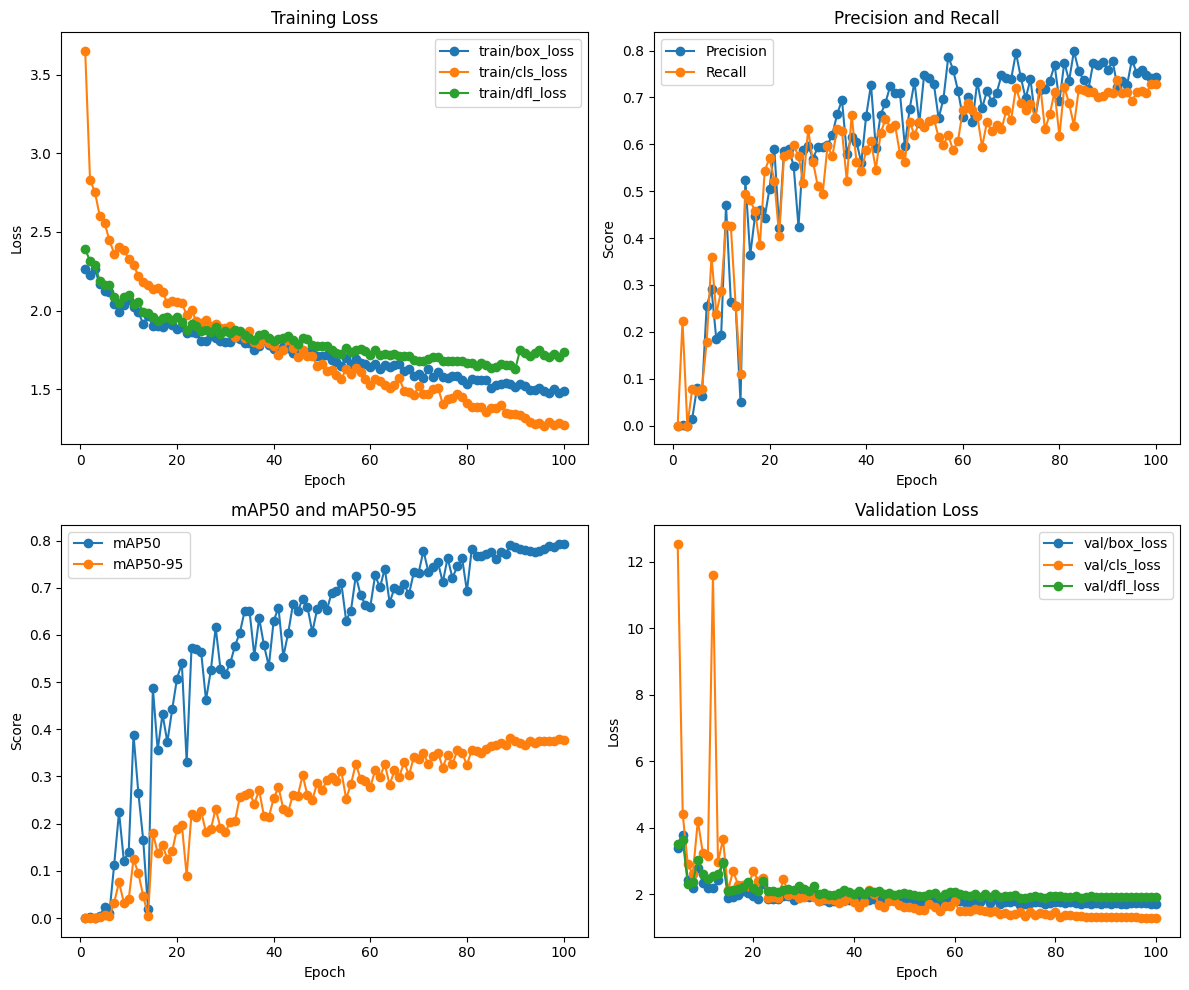

In [32]:
# Plotting selected metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting training loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='train/box_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss', marker='o')
axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss', marker='o')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plotting precision and recall
axes[0, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', marker='o')
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', marker='o')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()

# Plotting mAP50 and mAP50-95
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o')
axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o')
axes[1, 0].set_title('mAP50 and mAP50-95')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()

# Plotting validation loss
axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss', marker='o')
axes[1, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss', marker='o')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout and display
plt.tight_layout()

In [33]:
results = model.val()

Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12m summary (fused): 169 layers, 20,105,683 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2445.0±1013.5 MB/s, size: 193.8 KB)


val: Scanning /kaggle/working/val/labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


                   all        160        247      0.752      0.721       0.79      0.381


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.9ms preprocess, 16.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /kaggle/working/train/images/tb0050.png: 640x640 2 TBs, 19.2ms
Speed: 4.1ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


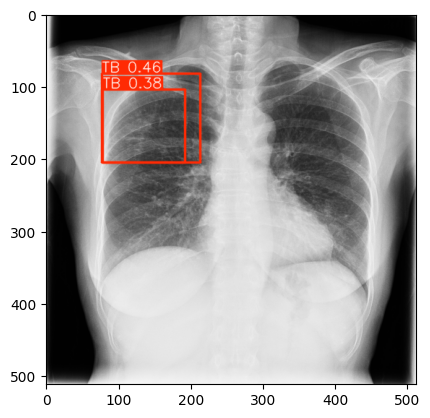

In [34]:
prediction = model.predict("/kaggle/working/train/images/tb0050.png")
plt.imshow(prediction[0].plot())

In [35]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.112 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.9 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 346.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 230.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 316.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.1s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 34.7s, saved as 'runs/detect/train/weights/best.onn

'runs/detect/train/weights/best.onnx'